In [17]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from skimage.feature import local_binary_pattern
import tensorflow as tf
from tensorflow.keras import layers, models
import seaborn as sns

In [18]:
import os
import cv2
import numpy as np

def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  
        if img is not None:
            img = cv2.resize(img, (128, 128))  
            images.append(img)
            labels.append(label)
    return images, labels

first_print_path = r"C:\Users\kabir\OneDrive\Desktop\QRCode\First Print"
second_print_path = r"C:\Users\kabir\OneDrive\Desktop\QRCode\Second Print"

first_prints, first_labels = load_images_from_folder(first_print_path, 1)
second_prints, second_labels = load_images_from_folder(second_print_path, 0)

X = np.array(first_prints + second_prints)
y = np.array(first_labels + second_labels)


In [19]:
X = X / 255.0  
X = X.reshape(-1, 128, 128, 1) 

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [21]:
def extract_lbp_features(image):
    radius = 3
    n_points = 8 * radius
    lbp = local_binary_pattern(image, n_points, radius, method="uniform")
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), density=True)
    return hist


In [22]:
X_features = np.array([extract_lbp_features(img.squeeze()) for img in X])
X_train_feat, X_test_feat, _, _ = train_test_split(X_features, y, test_size=0.2, random_state=42, stratify=y)

C:\Users\kabir\anaconda3\Lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


In [23]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_feat, y_train)
y_pred_rf = rf_model.predict(X_test_feat)

In [25]:
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
cm = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix:\n", cm)


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        20
           1       0.95      0.95      0.95        20

    accuracy                           0.95        40
   macro avg       0.95      0.95      0.95        40
weighted avg       0.95      0.95      0.95        40

Confusion Matrix:
 [[19  1]
 [ 1 19]]


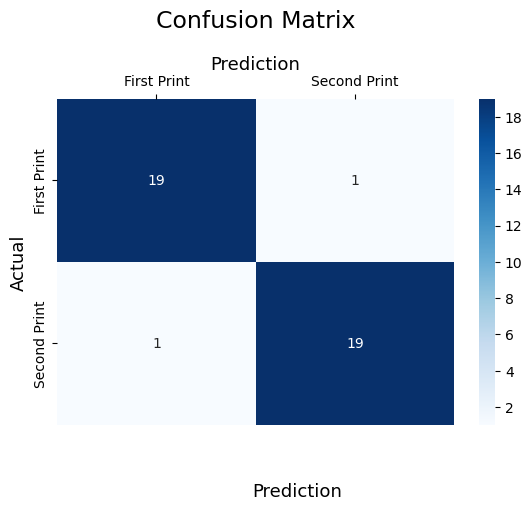

In [27]:
sns.heatmap(cm, 
            annot=True,
            fmt='g', 
            xticklabels=['First Print', 'Second Print'],
            yticklabels=['First Print', 'Second Print'],
            cmap='Blues')

plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top') 
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()

plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)
plt.show()

In [29]:
# CNN

cnn = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

C:\Users\kabir\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [31]:
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 663ms/step - accuracy: 0.4530 - loss: 1.4678 - val_accuracy: 0.5000 - val_loss: 0.6949
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 375ms/step - accuracy: 0.4780 - loss: 0.6924 - val_accuracy: 0.7000 - val_loss: 0.6846
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 306ms/step - accuracy: 0.7824 - loss: 0.6759 - val_accuracy: 0.8000 - val_loss: 0.6454
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step - accuracy: 0.6499 - loss: 0.6613 - val_accuracy: 0.5000 - val_loss: 0.6597
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 319ms/step - accuracy: 0.5428 - loss: 0.6319 - val_accuracy: 0.8750 - val_loss: 0.6202
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step - accuracy: 0.8524 - loss: 0.5897 - val_accuracy: 0.8500 - val_loss: 0.5309
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 338ms/step - accuracy: 0.8818 - loss: 0.4691 - val_accuracy: 0.8750 - val_loss: 0.4233
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 344ms/step - accuracy: 0.8897 - loss: 0.3224 - val_accuracy: 0.9000 - val_loss:

In [33]:
y_pred_cnn = (cnn.predict(X_test) > 0.5).astype(int)
print("\nCNN Classification Report:")
cr = classification_report(y_test, y_pred_cnn)
print(cr)
cm2 = confusion_matrix(y_test, y_pred_cnn)
print("Confusion Matrix:\n", cm2)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

CNN Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        20
           1       1.00      0.90      0.95        20

    accuracy                           0.95        40
   macro avg       0.95      0.95      0.95        40
weighted avg       0.95      0.95      0.95        40

Confusion Matrix:
 [[20  0]
 [ 2 18]]


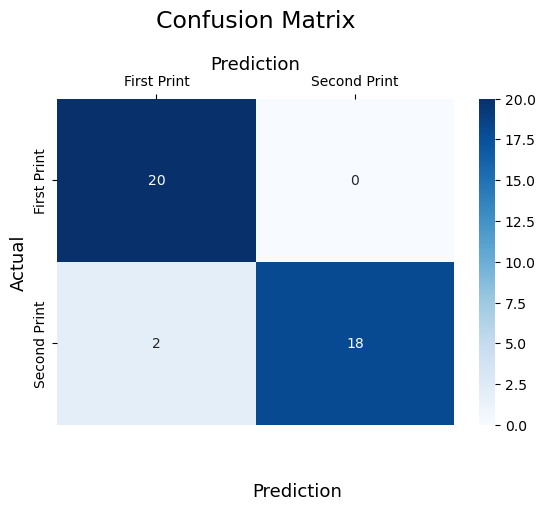

In [34]:
sns.heatmap(cm2, 
            annot=True,
            fmt='g', 
            xticklabels=['First Print', 'Second Print'],
            yticklabels=['First Print', 'Second Print'],
            cmap='Blues')

plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top') 
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()

plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)
plt.show()

In [38]:
rf_accuracy = accuracy_score(y_test, y_pred_rf)
cnn_accuracy = accuracy_score(y_test, y_pred_cnn)

In [39]:
print(f"\nRandom Forest Accuracy: {rf_accuracy:.4f}")
print(f"CNN Accuracy: {cnn_accuracy:.4f}")


Random Forest Accuracy: 0.9500
CNN Accuracy: 0.9500


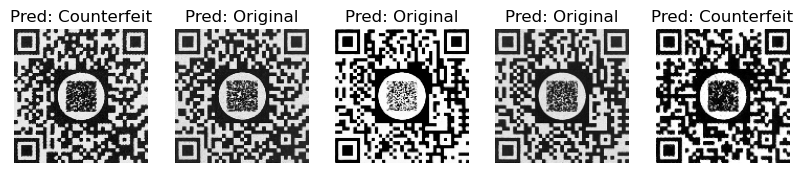

In [40]:
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_test[i].squeeze(), cmap='gray')
    plt.title(f"Pred: {'Original' if y_pred_cnn[i] == 1 else 'Counterfeit'}")
    plt.axis('off')
plt.show()

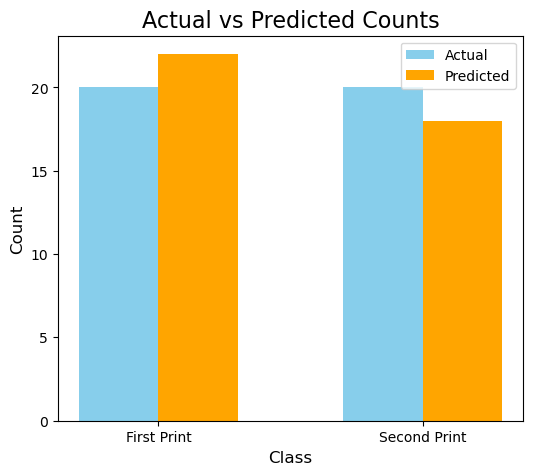

In [45]:
labels = ['First Print', 'Second Print']
actual_counts = np.sum(cm, axis=1) 
pred_counts = np.sum(cm, axis=0)   

bar_width = 0.3
index = np.arange(len(labels))

plt.figure(figsize=(6, 5))
plt.bar(index, actual_counts, bar_width, label='Actual', color='skyblue')
plt.bar(index + bar_width, pred_counts, bar_width, label='Predicted', color='orange')

plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Actual vs Predicted Counts', fontsize=16)
plt.xticks(index + bar_width / 2, labels)
plt.legend()
plt.show()